In [51]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows=None
pd.options.display.max_columns=None
import seaborn as sns
import gc
warnings.simplefilter('ignore')
matplotlib.rcParams['figure.dpi'] = 100
sns.set()
%matplotlib inline
import datetime
from sklearn.cluster import KMeans
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import random
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [52]:
myfavouritenumber = 42
seed = myfavouritenumber
random.seed(seed)

In [2]:
train_df=pd.read_csv('final_train.csv')
sites=pd.read_csv('sites_metadata.csv')
test_df=pd.read_csv('final_test.csv')

In [3]:
sites.rename(columns={'name':'Site'},inplace=True)

In [4]:
train_df=train_df.merge(sites,how='left',on='Site')
train_df['TimeStamp']=pd.to_datetime(train_df['TimeStamp'])

In [5]:
test_df=test_df.merge(sites,how='left',on='Site')
test_df['TimeStamp']=pd.to_datetime(test_df['TimeStamp'])

In [6]:
train_df.head()

,channel_id,Site,TimeStamp,pm2_5,pm10,s2_pm2_5,s2_pm10,latitude,longitude,country,region,district,city,county,sub_county,parish,street,formatted_name,altitude,greenness,landform_90,landform_270,aspect,distance_to_nearest_road,distance_to_nearest_primary_road,distance_to_nearest_tertiary_road,distance_to_nearest_unclassified_road,distance_to_nearest_residential_road,distance_to_nearest_secondary_road,distance_to_kampala_center,bearing_to_kampala_center
0,672528,"Kasharara, Rubirizi",2019-01-12 11:00:00,24.143333,26.253333,17.363333,17.556667,-0.265089,30.106887,Uganda,Western,Rubirizi,Rubirizi,Rubirizi,Rubiriziri town council,Kasharara,Mbarara - Kasese Road,NaN,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325
1,672528,"Kasharara, Rubirizi",2019-01-12 12:00:00,21.483333,22.496667,16.390000,18.133333,-0.265089,30.106887,Uganda,Western,Rubirizi,Rubirizi,Rubirizi,Rubiriziri town council,Kasharara,Mbarara - Kasese Road,NaN,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325
2,672528,"Kasharara, Rubirizi",2019-01-14 15:00:00,104.745714,115.884286,91.912857,100.761429,-0.265089,30.106887,Uganda,Western,Rubirizi,Rubirizi,Rubirizi,Rubiriziri town council,Kasharara,Mbarara - Kasese Road,NaN,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325
3,672528,"Kasharara, Rubirizi",2019-01-14 16:00:00,95.730000,107.880000,98.517391,106.456522,-0.265089,30.106887,Uganda,Western,Rubirizi,Rubirizi,Rubirizi,Rubiriziri town council,Kasharara,Mbarara - Kasese Road,NaN,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325
4,672528,"Kasharara, Rubirizi",2019-01-14 17:00:00,147.107826,159.262174,142.483478,149.680000,-0.265089,30.106887,Uganda,Western,Rubirizi,Rubirizi,Rubirizi,Rubiriziri town council,Kasharara,Mbarara - Kasese Road,NaN,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325


In [7]:
data=pd.concat([train_df,test_df])

In [8]:
data.shape

(595165, 31)

In [9]:
#drop constatnt fetaures
def drop_constant_feats(df):
    """
    Drops constant value columns
    """
    keep_columns = df.columns[df.nunique()>1]
    return df.loc[:,keep_columns].copy()

In [10]:
data=drop_constant_feats(data)

In [11]:
data.shape

(595165, 29)

In [12]:
data.head()

,channel_id,Site,TimeStamp,pm2_5,pm10,s2_pm2_5,s2_pm10,latitude,longitude,region,district,city,county,sub_county,parish,street,altitude,greenness,landform_90,landform_270,aspect,distance_to_nearest_road,distance_to_nearest_primary_road,distance_to_nearest_tertiary_road,distance_to_nearest_unclassified_road,distance_to_nearest_residential_road,distance_to_nearest_secondary_road,distance_to_kampala_center,bearing_to_kampala_center
0,672528,"Kasharara, Rubirizi",2019-01-12 11:00:00,24.143333,26.253333,17.363333,17.556667,-0.265089,30.106887,Western,Rubirizi,Rubirizi,Rubirizi,Rubiriziri town council,Kasharara,Mbarara - Kasese Road,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325
1,672528,"Kasharara, Rubirizi",2019-01-12 12:00:00,21.483333,22.496667,16.390000,18.133333,-0.265089,30.106887,Western,Rubirizi,Rubirizi,Rubirizi,Rubiriziri town council,Kasharara,Mbarara - Kasese Road,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325
2,672528,"Kasharara, Rubirizi",2019-01-14 15:00:00,104.745714,115.884286,91.912857,100.761429,-0.265089,30.106887,Western,Rubirizi,Rubirizi,Rubirizi,Rubiriziri town council,Kasharara,Mbarara - Kasese Road,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325
3,672528,"Kasharara, Rubirizi",2019-01-14 16:00:00,95.730000,107.880000,98.517391,106.456522,-0.265089,30.106887,Western,Rubirizi,Rubirizi,Rubirizi,Rubiriziri town council,Kasharara,Mbarara - Kasese Road,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325
4,672528,"Kasharara, Rubirizi",2019-01-14 17:00:00,147.107826,159.262174,142.483478,149.680000,-0.265089,30.106887,Western,Rubirizi,Rubirizi,Rubirizi,Rubiriziri town council,Kasharara,Mbarara - Kasese Road,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325


In [13]:
cat_cols=data.select_dtypes(include=['object']).columns.tolist()

In [14]:
#cat_cols

In [15]:
for col in cat_cols:
     data.loc[:,col] =data[col].astype(str).fillna('NONE')

In [16]:
for col in cat_cols:
     data.loc[:,col] =le.fit_transform(data[col])

In [17]:
data.head()

,channel_id,Site,TimeStamp,pm2_5,pm10,s2_pm2_5,s2_pm10,latitude,longitude,region,district,city,county,sub_county,parish,street,altitude,greenness,landform_90,landform_270,aspect,distance_to_nearest_road,distance_to_nearest_primary_road,distance_to_nearest_tertiary_road,distance_to_nearest_unclassified_road,distance_to_nearest_residential_road,distance_to_nearest_secondary_road,distance_to_kampala_center,bearing_to_kampala_center
0,672528,18,2019-01-12 11:00:00,24.143333,26.253333,17.363333,17.556667,-0.265089,30.106887,2,13,13,13,23,16,13,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325
1,672528,18,2019-01-12 12:00:00,21.483333,22.496667,16.390000,18.133333,-0.265089,30.106887,2,13,13,13,23,16,13,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325
2,672528,18,2019-01-14 15:00:00,104.745714,115.884286,91.912857,100.761429,-0.265089,30.106887,2,13,13,13,23,16,13,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325
3,672528,18,2019-01-14 16:00:00,95.730000,107.880000,98.517391,106.456522,-0.265089,30.106887,2,13,13,13,23,16,13,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325
4,672528,18,2019-01-14 17:00:00,147.107826,159.262174,142.483478,149.680000,-0.265089,30.106887,2,13,13,13,23,16,13,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325


In [18]:
data.shape

(595165, 29)

In [19]:
data=data.drop_duplicates(data.columns.tolist(),keep= 'last')

In [20]:
data.shape

(595165, 29)

In [21]:
data.tail()

,channel_id,Site,TimeStamp,pm2_5,pm10,s2_pm2_5,s2_pm10,latitude,longitude,region,district,city,county,sub_county,parish,street,altitude,greenness,landform_90,landform_270,aspect,distance_to_nearest_road,distance_to_nearest_primary_road,distance_to_nearest_tertiary_road,distance_to_nearest_unclassified_road,distance_to_nearest_residential_road,distance_to_nearest_secondary_road,distance_to_kampala_center,bearing_to_kampala_center
196293,930427,26,2021-11-16 02:00:00,37.779744,45.919231,36.595897,46.411282,0.2689,32.588,0,6,7,6,14,24,17,1171.499023,3293.4,31.0,-20.0,240.95,27.7,NaN,371.4,560.45,27.9,27.7,5.334824,179.0
196294,930427,26,2021-11-16 03:00:00,45.439500,56.460000,44.230000,55.967750,0.2689,32.588,0,6,7,6,14,24,17,1171.499023,3293.4,31.0,-20.0,240.95,27.7,NaN,371.4,560.45,27.9,27.7,5.334824,179.0
196295,930427,26,2021-11-16 04:00:00,43.961351,55.092162,43.155676,54.953784,0.2689,32.588,0,6,7,6,14,24,17,1171.499023,3293.4,31.0,-20.0,240.95,27.7,NaN,371.4,560.45,27.9,27.7,5.334824,179.0
196296,930427,26,2021-11-16 05:00:00,47.125897,59.116410,45.636667,58.615128,0.2689,32.588,0,6,7,6,14,24,17,1171.499023,3293.4,31.0,-20.0,240.95,27.7,NaN,371.4,560.45,27.9,27.7,5.334824,179.0
196297,930427,26,2021-11-16 06:00:00,35.251667,42.435000,33.688333,44.220000,0.2689,32.588,0,6,7,6,14,24,17,1171.499023,3293.4,31.0,-20.0,240.95,27.7,NaN,371.4,560.45,27.9,27.7,5.334824,179.0


## Feature Engineering

In [22]:
data.tail(3)

,channel_id,Site,TimeStamp,pm2_5,pm10,s2_pm2_5,s2_pm10,latitude,longitude,region,district,city,county,sub_county,parish,street,altitude,greenness,landform_90,landform_270,aspect,distance_to_nearest_road,distance_to_nearest_primary_road,distance_to_nearest_tertiary_road,distance_to_nearest_unclassified_road,distance_to_nearest_residential_road,distance_to_nearest_secondary_road,distance_to_kampala_center,bearing_to_kampala_center
196295,930427,26,2021-11-16 04:00:00,43.961351,55.092162,43.155676,54.953784,0.2689,32.588,0,6,7,6,14,24,17,1171.499023,3293.4,31.0,-20.0,240.95,27.7,NaN,371.4,560.45,27.9,27.7,5.334824,179.0
196296,930427,26,2021-11-16 05:00:00,47.125897,59.116410,45.636667,58.615128,0.2689,32.588,0,6,7,6,14,24,17,1171.499023,3293.4,31.0,-20.0,240.95,27.7,NaN,371.4,560.45,27.9,27.7,5.334824,179.0
196297,930427,26,2021-11-16 06:00:00,35.251667,42.435000,33.688333,44.220000,0.2689,32.588,0,6,7,6,14,24,17,1171.499023,3293.4,31.0,-20.0,240.95,27.7,NaN,371.4,560.45,27.9,27.7,5.334824,179.0


In [23]:
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'])

In [24]:
data['year'] = data['TimeStamp'].apply(lambda x: x.year)
data['month'] = data['TimeStamp'].apply(lambda x: x.month)
data['Day'] = data['TimeStamp'].apply(lambda x: x.day)
data['weekday'] = data['TimeStamp'].apply(lambda x: x.weekday())
data['hour'] = data['TimeStamp'].apply(lambda x: x.hour)
data['week'] = data['TimeStamp'].apply(lambda x: x.week)

In [25]:
data.head()

,channel_id,Site,TimeStamp,pm2_5,pm10,s2_pm2_5,s2_pm10,latitude,longitude,region,district,city,county,sub_county,parish,street,altitude,greenness,landform_90,landform_270,aspect,distance_to_nearest_road,distance_to_nearest_primary_road,distance_to_nearest_tertiary_road,distance_to_nearest_unclassified_road,distance_to_nearest_residential_road,distance_to_nearest_secondary_road,distance_to_kampala_center,bearing_to_kampala_center,year,month,Day,weekday,hour,week
0,672528,18,2019-01-12 11:00:00,24.143333,26.253333,17.363333,17.556667,-0.265089,30.106887,2,13,13,13,23,16,13,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325,2019,1,12,5,11,2
1,672528,18,2019-01-12 12:00:00,21.483333,22.496667,16.390000,18.133333,-0.265089,30.106887,2,13,13,13,23,16,13,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325,2019,1,12,5,12,2
2,672528,18,2019-01-14 15:00:00,104.745714,115.884286,91.912857,100.761429,-0.265089,30.106887,2,13,13,13,23,16,13,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325,2019,1,14,0,15,3
3,672528,18,2019-01-14 16:00:00,95.730000,107.880000,98.517391,106.456522,-0.265089,30.106887,2,13,13,13,23,16,13,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325,2019,1,14,0,16,3
4,672528,18,2019-01-14 17:00:00,147.107826,159.262174,142.483478,149.680000,-0.265089,30.106887,2,13,13,13,23,16,13,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325,2019,1,14,0,17,3


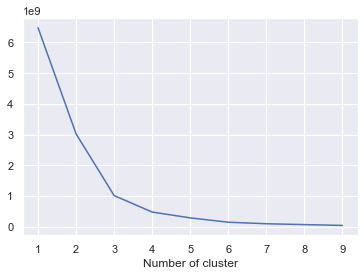

In [26]:
sse={}
all_data_cluster = data[['altitude']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(all_data_cluster)
    all_data_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [27]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data[['altitude']])
data['altitude_cluster'] = kmeans.predict(data[['altitude']])

In [28]:
data.tail(2)

,channel_id,Site,TimeStamp,pm2_5,pm10,s2_pm2_5,s2_pm10,latitude,longitude,region,district,city,county,sub_county,parish,street,altitude,greenness,landform_90,landform_270,aspect,distance_to_nearest_road,distance_to_nearest_primary_road,distance_to_nearest_tertiary_road,distance_to_nearest_unclassified_road,distance_to_nearest_residential_road,distance_to_nearest_secondary_road,distance_to_kampala_center,bearing_to_kampala_center,year,month,Day,weekday,hour,week,altitude_cluster
196296,930427,26,2021-11-16 05:00:00,47.125897,59.11641,45.636667,58.615128,0.2689,32.588,0,6,7,6,14,24,17,1171.499023,3293.4,31.0,-20.0,240.95,27.7,NaN,371.4,560.45,27.9,27.7,5.334824,179.0,2021,11,16,1,5,46,0
196297,930427,26,2021-11-16 06:00:00,35.251667,42.43500,33.688333,44.220000,0.2689,32.588,0,6,7,6,14,24,17,1171.499023,3293.4,31.0,-20.0,240.95,27.7,NaN,371.4,560.45,27.9,27.7,5.334824,179.0,2021,11,16,1,6,46,0


In [29]:
data.shape

(595165, 36)

In [32]:
data['aspect'] = data['aspect'].fillna(np.mean(data['aspect']))

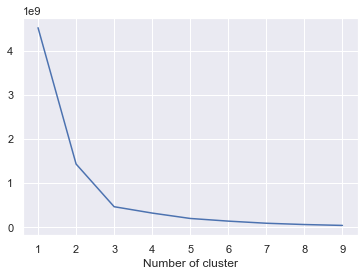

In [33]:
sse={}
all_data_cluster = data[['aspect']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(all_data_cluster)
    all_data_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [36]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data[['aspect']])
data['altitude_aspect'] = kmeans.predict(data[['aspect']])

In [35]:
data['greenness'] = data['greenness'].fillna(np.mean(data['greenness']))


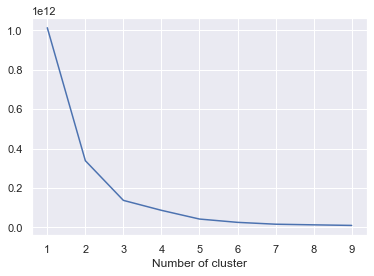

In [37]:
sse={}
all_data_cluster = data[['greenness']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(all_data_cluster)
    all_data_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [38]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data[['greenness']])
data['altitude_greenness'] = kmeans.predict(data[['greenness']])

In [39]:
data.head()

,channel_id,Site,TimeStamp,pm2_5,pm10,s2_pm2_5,s2_pm10,latitude,longitude,region,district,city,county,sub_county,parish,street,altitude,greenness,landform_90,landform_270,aspect,distance_to_nearest_road,distance_to_nearest_primary_road,distance_to_nearest_tertiary_road,distance_to_nearest_unclassified_road,distance_to_nearest_residential_road,distance_to_nearest_secondary_road,distance_to_kampala_center,bearing_to_kampala_center,year,month,Day,weekday,hour,week,altitude_cluster,altitude_aspect,altitude_greenness
0,672528,18,2019-01-12 11:00:00,24.143333,26.253333,17.363333,17.556667,-0.265089,30.106887,2,13,13,13,23,16,13,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325,2019,1,12,5,11,2,1,2,1
1,672528,18,2019-01-12 12:00:00,21.483333,22.496667,16.390000,18.133333,-0.265089,30.106887,2,13,13,13,23,16,13,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325,2019,1,12,5,12,2,1,2,1
2,672528,18,2019-01-14 15:00:00,104.745714,115.884286,91.912857,100.761429,-0.265089,30.106887,2,13,13,13,23,16,13,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325,2019,1,14,0,15,3,1,2,1
3,672528,18,2019-01-14 16:00:00,95.730000,107.880000,98.517391,106.456522,-0.265089,30.106887,2,13,13,13,23,16,13,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325,2019,1,14,0,16,3,1,2,1
4,672528,18,2019-01-14 17:00:00,147.107826,159.262174,142.483478,149.680000,-0.265089,30.106887,2,13,13,13,23,16,13,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.1,396.87,542.79,NaN,283.538298,256.793325,2019,1,14,0,17,3,1,2,1


In [41]:
data['pm2_5'].min()

0.0

In [42]:
data['pm2_5'].max()

4068.37

In [43]:
data['pm2_5'].mean()

58.707442039123585

In [45]:
n=train_df.shape[0]
df_train=data[:n]
df_test=data[n:]

In [46]:
features=[x for x in df_train.columns if x not in ['channel_id','TimeStamp','pm10','s2_pm2_5','s2_pm10','pm2_5']]

In [47]:
features

['Site',
 'latitude',
 'longitude',
 'region',
 'district',
 'city',
 'county',
 'sub_county',
 'parish',
 'street',
 'altitude',
 'greenness',
 'landform_90',
 'landform_270',
 'aspect',
 'distance_to_nearest_road',
 'distance_to_nearest_primary_road',
 'distance_to_nearest_tertiary_road',
 'distance_to_nearest_unclassified_road',
 'distance_to_nearest_residential_road',
 'distance_to_nearest_secondary_road',
 'distance_to_kampala_center',
 'bearing_to_kampala_center',
 'year',
 'month',
 'Day',
 'weekday',
 'hour',
 'week',
 'altitude_cluster',
 'altitude_aspect',
 'altitude_greenness']

In [48]:
X=df_train[features]
y=np.log1p(df_train['pm2_5'])

In [54]:
X_half_1 = X[:int(X.shape[0] / 2)]
X_half_2 = X[int(X.shape[0] / 2):]

y_half_1 = y[:int(X.shape[0] / 2)]
y_half_2 = y[int(X.shape[0] / 2):]

categorical_features = ["Site", "month", "weekday", "hour", "week",'year','Day']

d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

watchlist_1 = [d_half_1, d_half_2]
watchlist_2 = [d_half_2, d_half_1]

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 50,
    "learning_rate": 0.005,
    "feature_fraction": 0.75,
    "reg_lambda": 2,
    "metric": "rmse"
}

print("build model with first half and validating on second half:")
model_half_1 = lgb.train(params, train_set=d_half_1, num_boost_round=2000, valid_sets=watchlist_1, verbose_eval=100, early_stopping_rounds=100)

print("build model with second half and validating on first half:")
model_half_2 = lgb.train(params, train_set=d_half_2, num_boost_round=2000, valid_sets=watchlist_2, verbose_eval=100, early_stopping_rounds=100)

build model with first half and validating on second half:
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 500
[LightGBM] [Info] Number of data points in the train set: 199433, number of used features: 32
[LightGBM] [Info] Start training from score 3.679765
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.577407	valid_1's rmse: 0.700117
[200]	training's rmse: 0.526485	valid_1's rmse: 0.674373
[300]	training's rmse: 0.49651	valid_1's rmse: 0.659016
[400]	training's rmse: 0.477584	valid_1's rmse: 0.649233
[500]	training's rmse: 0.464887	valid_1's rmse: 0.643201
[600]	training's rmse: 0.454813	valid_1's rmse: 

### Features of Importance

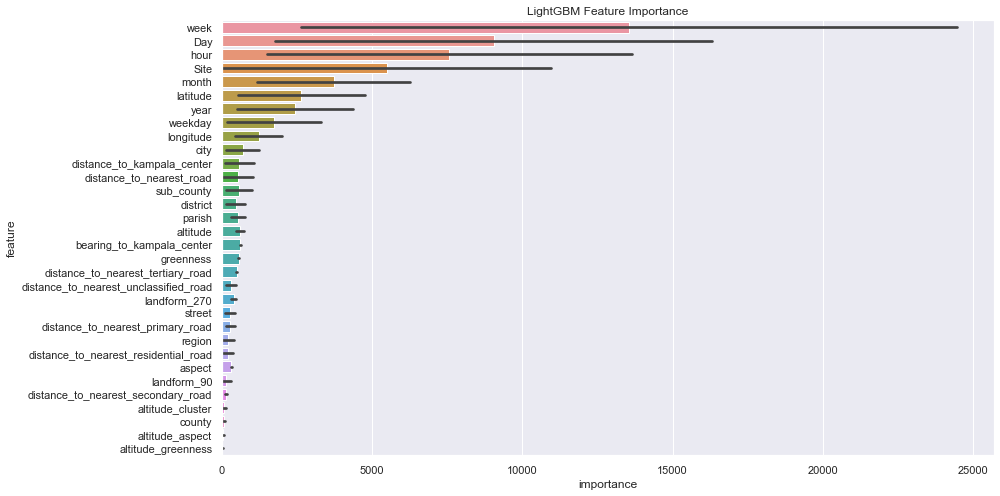

In [56]:
df_feat_imp_1 = pd.DataFrame()
df_feat_imp_1["feature"] = X.columns.values
df_feat_imp_1["importance"] = model_half_1.feature_importance()
df_feat_imp_1["half"] = 1

df_feat_imp_2 = pd.DataFrame()
df_feat_imp_2["feature"] = X.columns.values
df_feat_imp_2["importance"] = model_half_2.feature_importance()
df_feat_imp_2["half"] = 2

df_fimp = pd.concat([df_feat_imp_1, df_feat_imp_2], axis=0)

plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

#### Apply Model on Test_Data

In [57]:
X_test=df_test[features]

In [58]:
pred = np.expm1(model_half_1.predict(X_test, num_iteration=model_half_1.best_iteration)) / 2
pred += np.expm1(model_half_2.predict(X_test, num_iteration=model_half_2.best_iteration)) / 2

In [59]:
len(pred)

196298

In [60]:
df_test.shape[0]

196298

In [61]:
pred[:5]

array([49.12859173, 40.80794223, 37.05318418, 35.84931334, 35.08054644])

## Evaluation

In [62]:
def rmse(y_true,y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))


In [64]:
rmse(np.log1p(df_test['pm2_5']),np.log1p(pred))

0.8282413986444274